In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Introduction + Set-up

Machine learning has a phenomenal range of applications, including in health and diagnostics. This tutorial will explain the complete pipeline from loading data to predicting results, and it will explain how to build an X-ray image classification model from scratch to predict whether an X-ray scan shows presence of pneumonia. This is especially useful during these current times as COVID-19 is known to cause pneumonia.

This tutorial will explain how to utilize TPUs efficiently, load in image data, build and train a convolution neural network, finetune and regularize the model, and predict results. Data augmentation is not included in the model because X-ray scans are only taken in a specific orientation, and variations such as flips and rotations will not exist in real X-ray images. For a tutorial on image data augmentation, check out this [tutorial](https://www.kaggle.com/amyjang/tensorflow-data-augmentation-efficientnet).

Run the following cell to load the necessary packages. Make sure to change the Accelerator on the right to `TPU`.

In [2]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

D0713 02:11:11.402765871      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0713 02:11:11.402790980      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0713 02:11:11.402795148      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0713 02:11:11.402798441      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0713 02:11:11.402801271      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0713 02:11:11.402804501      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0713 02:11:11.402807552      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0713 02:11:11.

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Number of replicas: 8
2.12.0


We need a Google Cloud link to our data to load the data using a TPU. While we're at it, we instantiate constant variables. It is generally better practice to use constant variables instead of hard-coding numbers.

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [256, 256]
IMG_SIZE = 256
EPOCHS = 30

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/chest-xray-pneumonia


# 2. Load the data

The Chest X-ray data we are using from [*Cell*](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) divides the data into train, val, and test files. There are only 16 files in the validation folder, and we would prefer to have a less extreme division between the training and the validation set. We will append the validation files and create a new split that resembes the standard 80:20 division instead.

In [4]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

Run the following cell to see how many healthy/normal chest X-rays we have and how many pneumonia chest X-rays we have.

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1059
Pneumonia images count in training set: 3126


Notice that the there are way more images that are classified as pneumonia than normal. This shows that we have a imbalance in our data. We will correct for this imbalance later on in our notebook.

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person102_virus_189.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0749-0001.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0582-0001.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person596_bacteria_2446.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1316_virus_2271.jpeg'


Run the following cell to see how many images we have in our training dataset and how many images we have in our validation set. Verify that the ratio of images is 80:20.

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


As expected, we have two labels for our images.

In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "/chest_xray/train/*"))])
CLASS_NAMES

array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

Currently our dataset is just a list of filenames. We want to map each filename to the corresponding (image, label) pair. The following methods will help us do that.

As we only have two labels, we will rewrite the label so that `1` or `True` indicates pneumonia and `0` or `False` indicates normal.

In [9]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

The images originally have values that range from [0, 255]. CNNs work better with smaller numbers so we will scale this down.

In [10]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [11]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Let's visualize the shape of an (image, label) pair.

In [13]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

# 3. Visualize the dataset

First, let's use buffered prefetching so we can yield data from disk without having I/O become blocking.

In [14]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Call the next batch iteration of the training data.

In [15]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

Define the method to show the images in the batch.

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

As the method takes in numpy arrays as its parameters, call the numpy function on the batches to return the tensor in numpy array form.

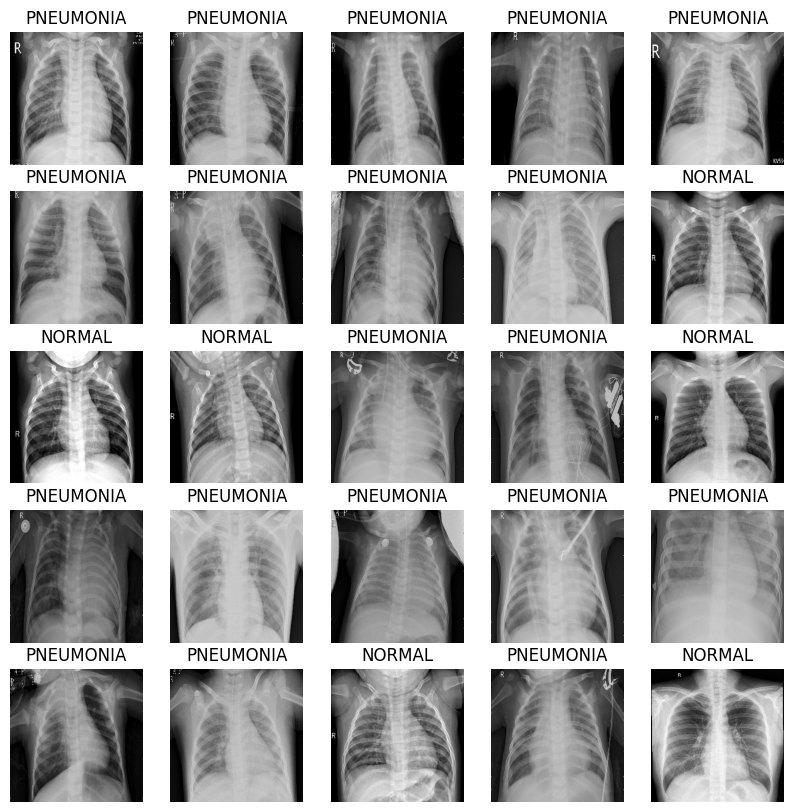

In [17]:
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. Build the CNN

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.layers import Input, MaxPooling2D, Conv2DTranspose, concatenate, SeparableConv2D
from keras import Model

In [19]:
def unet_combination_build(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    # U-net block
    inputs = tf.keras.Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    
    # Classification layer (classical CNN)
    # init block
    cnn_conv1 = Conv2D(16, kernel_size=(3, 3), activation='relu')(conv10)
    cnn_conv2 = Conv2D(16, kernel_size=(3, 3), activation='relu')(cnn_conv1)
    pooling1 = MaxPool2D(pool_size=(2, 2))(cnn_conv2)
    
    # conv block 32
    cnn_conv3 = SeparableConv2D(32, kernel_size=(3, 3), activation='relu')(pooling1)
    cnn_conv4 = SeparableConv2D(32, kernel_size=(3, 3), activation='relu')(cnn_conv3)
    batch1 = BatchNormalization()(cnn_conv4)
    pooling2 = MaxPool2D(pool_size=(2, 2))(cnn_conv4)
    
    # conv block 64
    cnn_conv5 = SeparableConv2D(64, kernel_size=(3, 3), activation='relu')(pooling2)
    cnn_conv6 = SeparableConv2D(64, kernel_size=(3, 3), activation='relu')(cnn_conv5)
    batch2 = BatchNormalization()(cnn_conv6)
    pooling3 = MaxPool2D(pool_size=(2, 2))(cnn_conv6)

    # conv block 128
    cnn_conv7 = SeparableConv2D(128, kernel_size=(3, 3), activation='relu')(pooling3)
    cnn_conv8 = SeparableConv2D(128, kernel_size=(3, 3), activation='relu')(cnn_conv7)
    batch3 = BatchNormalization()(cnn_conv8)
    pooling4 = MaxPool2D(pool_size=(2, 2))(cnn_conv8)
    dropout1 = Dropout(0.2)(pooling4)
    
    # conv block 256
    cnn_conv9 = SeparableConv2D(256, kernel_size=(3, 3), activation='relu')(pooling4)
    cnn_conv10 = SeparableConv2D(256, kernel_size=(3, 3), activation='relu')(cnn_conv9)
    batch4 = BatchNormalization()(cnn_conv10)
    pooling5 = MaxPool2D(pool_size=(2, 2))(cnn_conv10)
    dropout2 = Dropout(0.2)(pooling5)
    
    # Flatten
    flatten = Flatten()(pooling5)
    
    # dense block 512
    dense1 = Dense(512, activation='relu')(flatten)
    dropout = Dropout(0.7)(dense1)
    
    # dense block 128
    dense2 = Dense(128, activation='relu')(dense1)
    dropout = Dropout(0.5)(dense2)
    
    # dense block 64
    dense3 = Dense(64, activation='relu')(dense2)
    dropout = Dropout(0.3)(dense3)
    
    output = Dense(1, activation='sigmoid')(dense3)

    return Model(inputs=[inputs], outputs=[output])

# 5. Correct for data imbalance

In [20]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.08242917])

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.98
Weight for class 1: 0.67


# 6. Train the model

In [22]:
with strategy.scope():
    model = unet_combination_build()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/30


2023-07-13 02:11:53.041912: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_164/ReadVariableOp.
2023-07-13 02:11:53.343631: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_164/ReadVariableOp.


32/32 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.3206 - precision: 0.7156 - recall: 0.1497

2023-07-13 02:12:27.381668: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
2023-07-13 02:12:27.463740: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


32/32 [==============================] - 69s 1s/step - loss: 0.6937 - accuracy: 0.3206 - precision: 0.7156 - recall: 0.1497 - val_loss: 0.6938 - val_accuracy: 0.2734 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
32/32 [==============================] - 8s 242ms/step - loss: 0.6913 - accuracy: 0.6978 - precision: 0.7465 - recall: 0.9032 - val_loss: 0.6921 - val_accuracy: 0.7217 - val_precision: 0.7217 - val_recall: 1.0000
Epoch 3/30
32/32 [==============================] - 8s 238ms/step - loss: 0.6933 - accuracy: 0.7468 - precision: 0.7468 - recall: 1.0000 - val_loss: 0.6910 - val_accuracy: 0.7236 - val_precision: 0.7236 - val_recall: 1.0000
Epoch 4/30
32/32 [==============================] - 8s 238ms/step - loss: 0.6967 - accuracy: 0.2993 - precision: 0.7266 - recall: 0.0917 - val_loss: 0.6950 - val_accuracy: 0.2803 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
32/32 [==============================] - 8s 240ms/step - loss: 0.6956 - accuracy: 0.6160 -

# 7. Finetune the model

In [40]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [41]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.00001, 2)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [42]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/100
32/32 [==============================] - 8s 266ms/step - loss: 0.6922 - accuracy: 0.7480 - precision: 0.7480 - recall: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.7246 - val_precision: 0.7246 - val_recall: 1.0000 - lr: 1.0000e-05
Epoch 2/100
32/32 [==============================] - 7s 233ms/step - loss: 0.6950 - accuracy: 0.7449 - precision: 0.7449 - recall: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.7217 - val_precision: 0.7217 - val_recall: 1.0000 - lr: 3.1623e-06
Epoch 3/100
32/32 [==============================] - 7s 233ms/step - loss: 0.6926 - accuracy: 0.7476 - precision: 0.7476 - recall: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.7246 - val_precision: 0.7246 - val_recall: 1.0000 - lr: 1.0000e-06
Epoch 4/100
32/32 [==============================] - 7s 234ms/step - loss: 0.6933 - accuracy: 0.7468 - precision: 0.7468 - recall: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.7217 - val_precision: 0.7217 - val_recall: 1.0000 - lr: 3.1623e-07
Epoch 5/100
32/32 [=============

# 8. Visualizing model performance


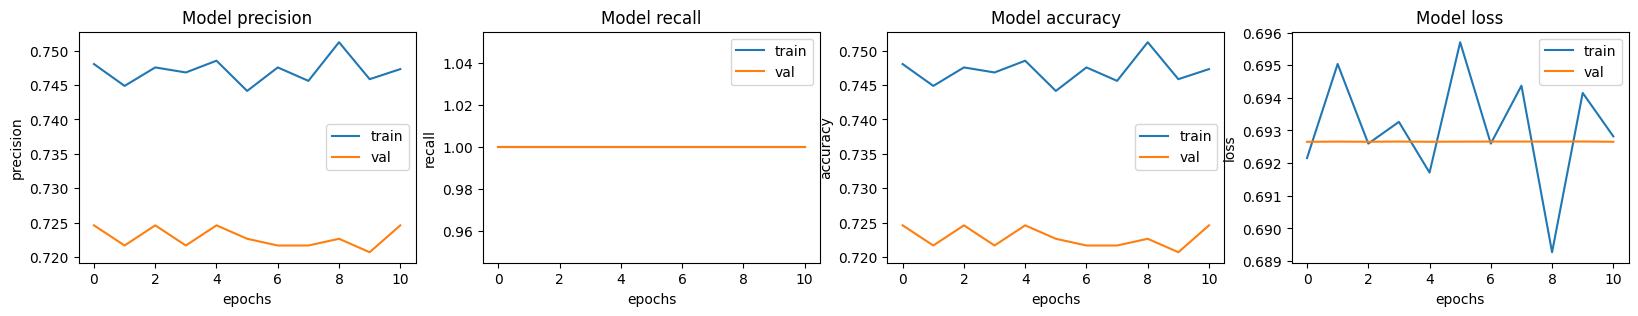

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 9. Predict and evaluate results

In [44]:
loss, acc, prec, rec = model.evaluate(test_ds)

5/5 [==============================] - 2s 201ms/step - loss: 0.6929 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
